# Rastermap prototype
used for conveting data for rastermap input

In [13]:
import sys
import json
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from rastermap import Rastermap, utils

sys.path.append("/home/gergely/code/sleep/src")

from suite2p_class import Suite2p as s2p
import imaging_data_class as idc
import behavior_class as bc

In [6]:
mouse_id = "140302_3"
imaging_data = idc.ImagingData(mouse_id=mouse_id)
s2p_folders = [
    (index, folder) for index, folder in enumerate(imaging_data.find_suite2p_folders())
]
s2p_folders

Searching for suite2p folders in /data2/gergely/invivo_DATA/sleep/140302_3


[(0,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-001/TSeries-12212023-1051-001.sima/suite2p'),
 (1,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-002/TSeries-12212023-1051-002.sima/suite2p'),
 (2,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess01-001/TSeries-12112023-0825_sess01-001_Cycle00001_Element00001.sima/suite2p'),
 (3,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess02_MC-002/TSeries-12112023-0825_sess02_MC-002.sima/suite2p'),
 (4,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_MC-003/TSeries-12132023-0849_GC_MC-003.sima/suite2p'),
 (5,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_dendrite-004/TSeries-12132023-0849_GC_dendrite-004.sima/suite2p'),
 (6,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC-002/TSeries-12132023-0849_GC-002.sima/suite2p'),
 (7,
  '/data2/gergely/invivo_DA

In [7]:
s2p_data = s2p(s2p_folders[9][1])
spikes = s2p_data.get_spikes()

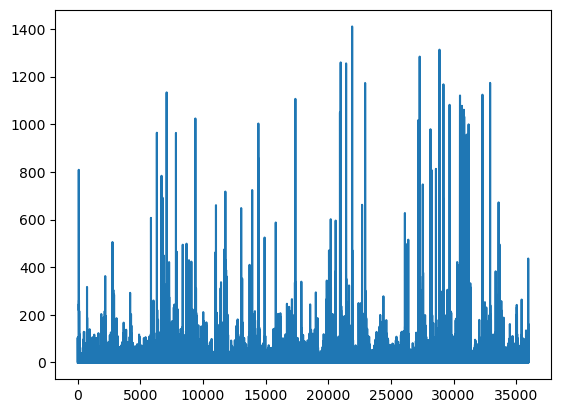

In [8]:
plt.plot(spikes[0])

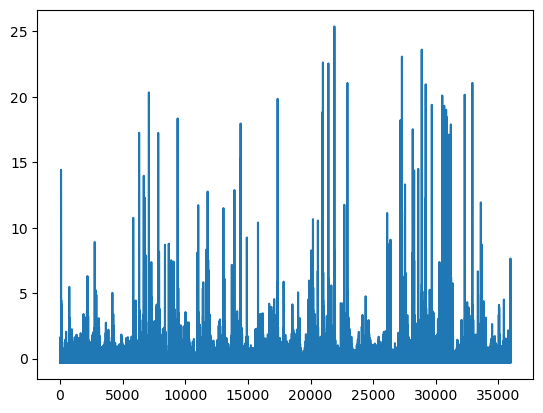

In [9]:
# z scoring
n_neurons, n_time = spikes.shape
spks = zscore(spikes, axis=1)
plt.plot(spks[0])

In [10]:
spks.shape

(93, 36000)

In [67]:
behavior = bc.behaviorData(mouse_id=mouse_id)
behavior_folders = [
    (index, folder) for index, folder in enumerate(behavior.find_behavior_folders())
]
processed_behavior = behavior_folders[0][1]
with open(join(processed_behavior, "filtered_velocity.json"), "r") as f:
    speed = np.array(json.load(f))

with open(join(processed_behavior, "140302_3_20240118121644_932_sleep.json"), "r") as f:
    beh = json.load(f)
position = np.array(beh[0]["data"]["treadmillPosition"])

with open(join(processed_behavior, "mobility_immobility.json"), "r") as f:
    mob_immob = np.array(json.load(f))

Searching for behavior folders in /data2/gergely/invivo_DATA/sleep/140302_3
Searching for behavior folders in /data2/gergely/invivo_DATA/sleep/140302_3


In [56]:
model = Rastermap(
    n_clusters=8,  # None turns off clustering and sorts single neurons
    n_PCs=26,  # use fewer PCs than neurons
    locality=0.15,  # some locality in sorting (this is a value from 0-1)
    time_lag_window=15,  # use future timepoints to compute correlation
    grid_upsample=0,  # 0 turns off upsampling since we're using single neurons
).fit(spks)
y = model.embedding  # neurons x 1
isort = model.isort

normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.03sec
sorting activity: 93 valid samples by 36000 timepoints
n_PCs = 26 computed, 0.09sec
5 clusters computed, time 0.10sec
clusters sorted, time 0.10sec
rastermap complete, time 0.10sec


compute tuning curve for each neuron

In [57]:
n_pos = 100
bins = np.arange(0, 1 + 1.0 / n_pos, 1.0 / n_pos)
ibin = np.digitize(position, bins) - 1
n_bins = ibin.max()
inan = np.isnan(position)
ibin[inan] = -1
tcurves = np.zeros((spks.shape[0], n_bins))
for b in range(n_bins):
    tcurves[:, b] = spks[:, ibin == b].mean(axis=1)
tcurves -= tcurves.mean(axis=1, keepdims=True)

56
56


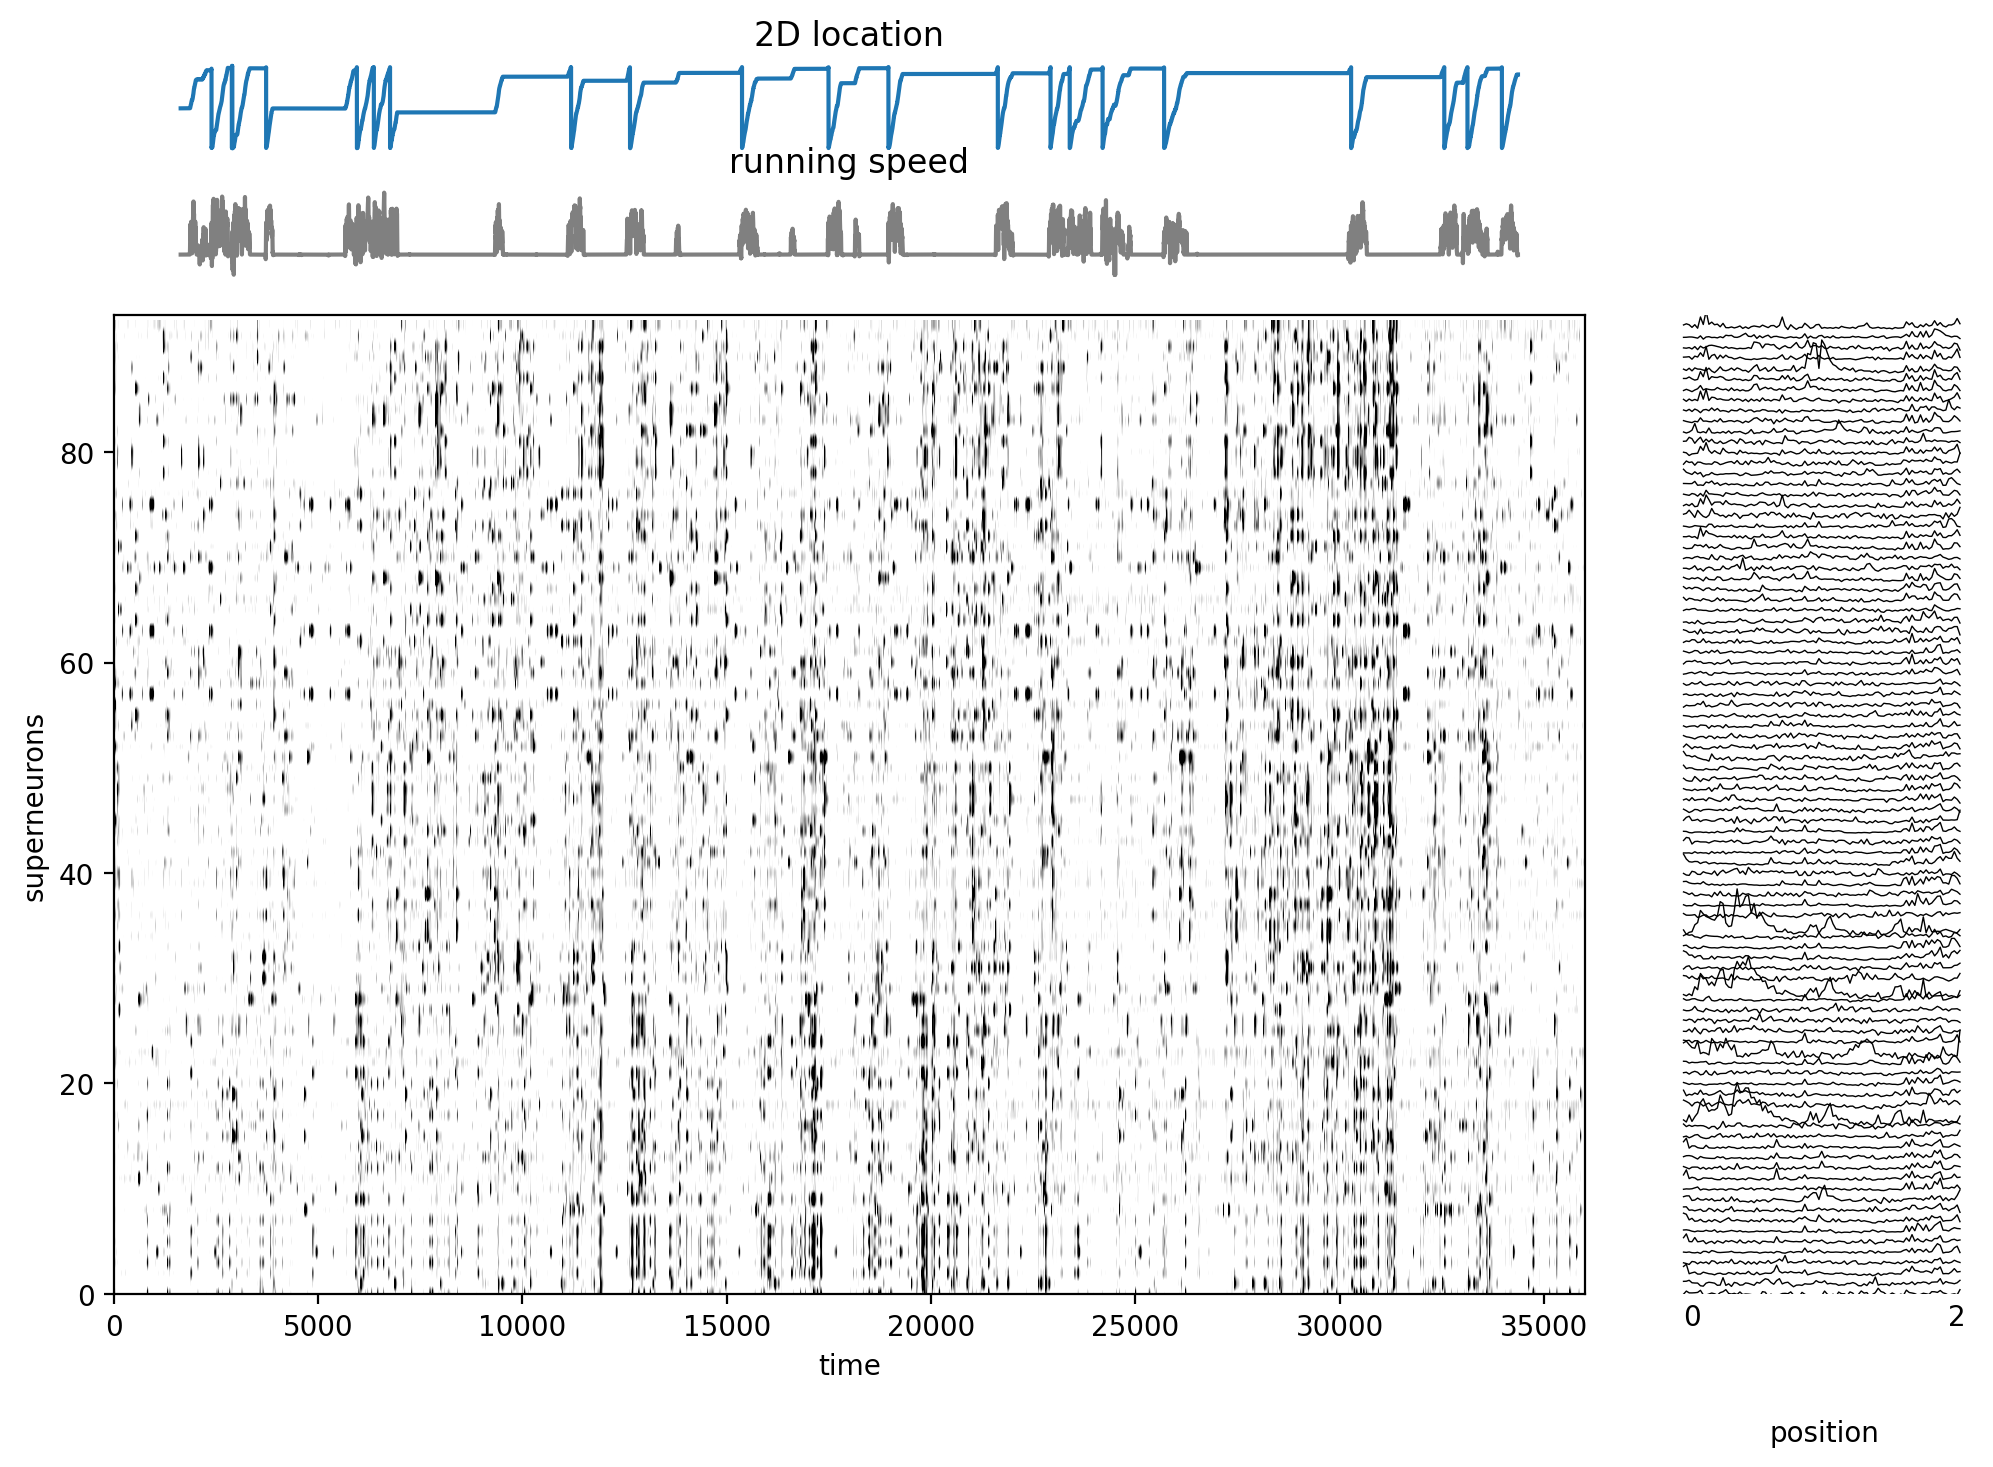

In [89]:
# make figure with grid for easy plotting
fig = plt.figure(figsize=(12, 8), dpi=200)
grid = plt.GridSpec(10, 24, figure=fig, wspace=0.1, hspace=0.4)

# plot location
ax = plt.subplot(grid[0, :-5])
ax.plot(position)  # , color=kp_colors[0])
# ax.set_xlim([0, xmax - xmin])
ax.axis("off")
ax.set_title("2D location")

# plot running speed
ax = plt.subplot(grid[1, :-5])
ax.plot(speed, color=0.5 * np.ones(3))
# ax.set_xlim([0, xmax - xmin])
ax.axis("off")
ax.set_title("running speed")

# plot sorted neural activity
ax = plt.subplot(grid[2:, :-5])
ax.imshow(spks[isort], cmap="gray_r", vmin=0, vmax=1.2, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")

immobility = mob_immob.astype(int)
# Assuming x-axis aligns with the length of immobility array
x = np.arange(len(immobility))

# Find where immobility periods start and end
immobility_starts = np.where(np.diff(immobility) == -1)[0] + 1
immobility_ends = np.where(np.diff(immobility) == 1)[0]
print(len(immobility_starts))
print(len(immobility_ends))

# Plot immobility periods
for start, end in zip(immobility_starts, immobility_ends):
    ax.fill_between(x[start:end], 0, spks.shape[0], color="#FA8072", alpha=0.5)

# plot single-neuron tuning curves
ax = plt.subplot(grid[2:, -4:])
x = np.arange(0, n_bins)
dy = 2
# xpad = n_pos / 10
nn = spks.shape[0]
for t in range(len(tcurves)):
    ax.plot(x, tcurves[isort[t], :n_pos] * dy - dy / 2 + nn - t, color="k", lw=0.5)

ax.text(n_pos / 2, -14, "position", ha="center")
ax.text(0, -3, "0")
ax.text(n_pos, -3, "2", ha="right")
ax.set_ylim([0, nn])
ax.axis("off")
plt.show()
# plt.tight_layout()

In [87]:
len(immobility)

36000

Text(0, 0.5, 'superneurons')

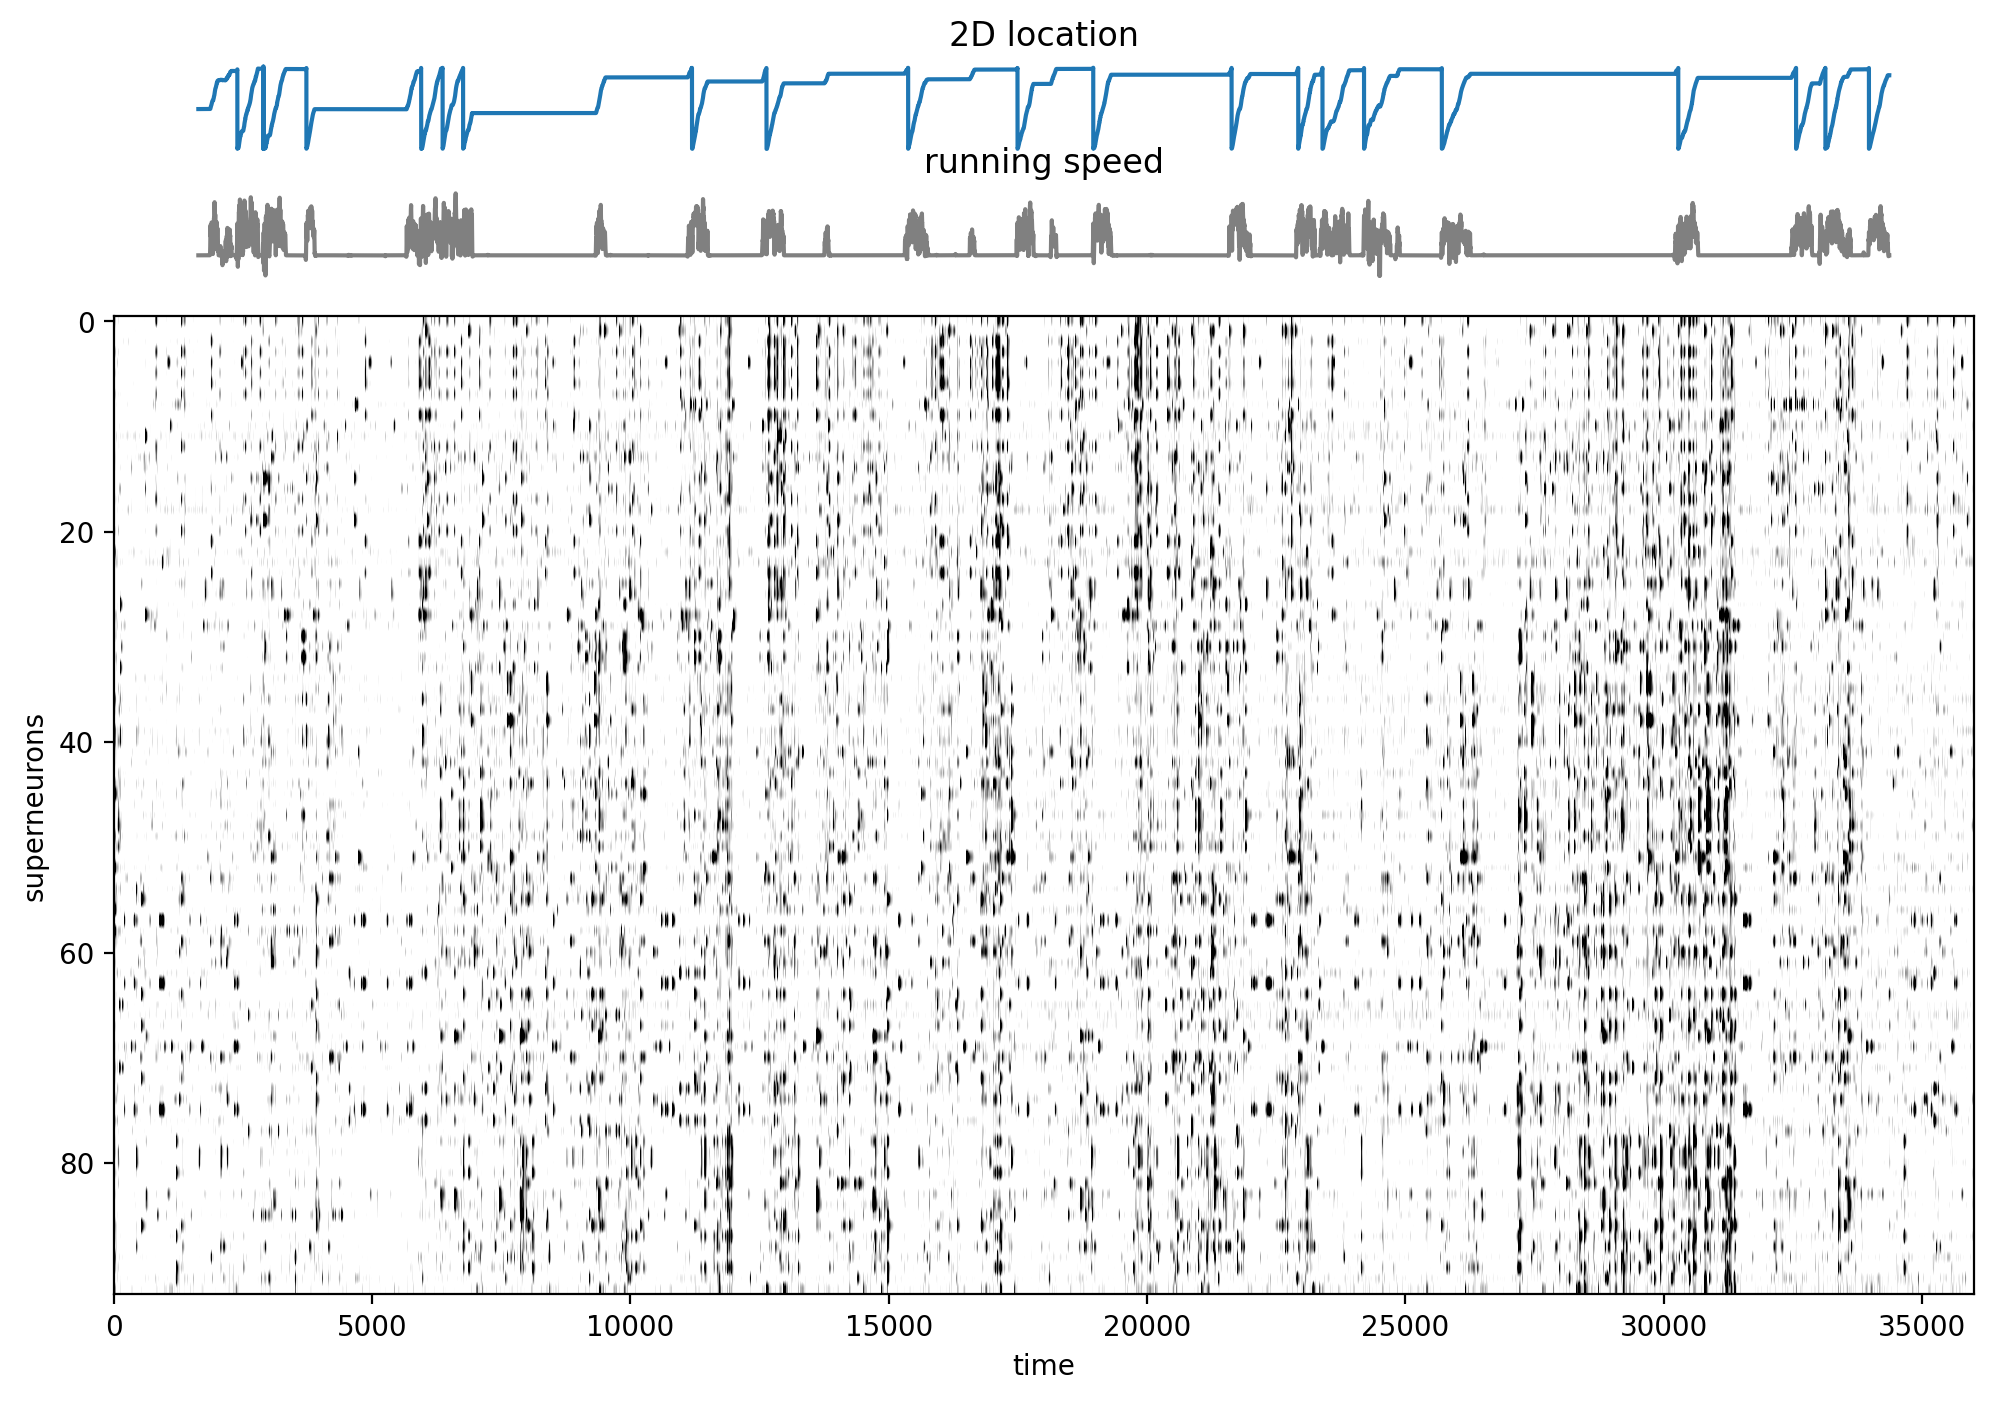

In [62]:
# make figure with grid for easy plotting
fig = plt.figure(figsize=(12, 8), dpi=200)
grid = plt.GridSpec(10, 24, figure=fig, wspace=0.1, hspace=0.4)

# plot location
ax = plt.subplot(grid[0, :])  # Adjusted to span all columns
ax.plot(position)  # , color=kp_colors[0])
# ax.set_xlim([0, xmax - xmin])
ax.axis("off")
ax.set_title("2D location")

# plot running speed
ax = plt.subplot(grid[1, :])  # Adjusted to span all columns
ax.plot(speed, color=0.5 * np.ones(3))
# ax.set_xlim([0, xmax - xmin])
ax.axis("off")
ax.set_title("running speed")

# plot sorted neural activity
ax = plt.subplot(grid[2:, :])  # Adjusted to span all columns
ax.imshow(spks[isort], cmap="gray_r", vmin=0, vmax=1.2, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")